# Function:

This notebook takes the room and object networks and uses them as a mask to extract the classifier evidence for rooms or objects (depending on the network) from recall data (GRs and FRs).




# Import

In [1]:
ls -lt ../PythonData2024/Output/brainmaps/

total 1066240
-rw-rw-r--. 1 rmasis normanlab 51881500 Aug  8 11:38 20250807_partialcorr_reliability2evidence_RRCNcontrol.pkl
-rw-rw-r--. 1 rmasis normanlab 69451418 Aug  8 10:23 20250807_RRCNs_to_reliability_and_ROCN.pkl
-rw-rw-r--. 1 rmasis normanlab 22037689 Aug  2 11:54 20250801_reliability2RecallBehav.pkl
-rw-rw-r--. 1 rmasis normanlab  7715863 Jul  1 15:33 20250524_ClassifyRecalls_ConfMatAccuracy_RoomsOnObjectEvents_shift4.pkl
-rw-rw-r--. 1 rmasis normanlab 51944890 May 26 13:27 20250524_reliability2efeatures.pkl
-rw-rw-r--. 1 rmasis normanlab 45608255 May 26 12:32 20250524_reliability2evidence.pkl
-rw-rw-r--. 1 rmasis normanlab 34167876 May 24 16:42 20250524_partialcorr_reliability2evidence_RRCNcontrol.pkl
-rw-rw-r--. 1 rmasis normanlab 69491381 Apr 28 17:36 20250425_reliability2efeatures.pkl
-rw-rw-r--. 1 rmasis normanlab 52293428 Apr 23 16:49 202504232_reliability2efeatures.pkl
-rw-rw-r--. 1 rmasis normanlab 67003198 Apr 23 14:01 20250423_reliability2efeatures.pkl
-rw-rw-r--. 1

In [1]:
from tqdm import tqdm_notebook
import deepdish as dd
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats
from _searchlight_util import *
import matplotlib.pyplot as plt
from _classification_util import Convert_SourceItem_to_PairedItem_Order
from _mempal_util import room_obj_assignments, save_obj, load_obj, create_dirs, subject_ids

trials = ['GR0', 'GR1', 'GR2', 'GR3','GR4', 'GR5', 'GR6', 'GR7','GR8', 'GR9', 'GR10','FR']
roi = 'SL'
nSubj =25

In [2]:
def GetRecallEvidence(date, roi, shift, win_size, measure_list, betatypes, dirpath = '../PythonData2024/Output/ClassifyRecalls'):
    '''
    - grabs the whole-brain results of classifying recalls (GRs+FRs)
    - returns 'scores' which is a dict with the data in measure_list
    
    '''

    trials = ['GR0', 'GR1', 'GR2', 'GR3','GR4', 'GR5', 'GR6', 'GR7','GR8', 'GR9', 'GR10','FR']

    nPerm = 1000
    nTrials = len(trials)
    nItems   = 23

    
    scores = {}

    for betatype in tqdm_notebook(betatypes):
        scores[betatype] = {}

        print("...BETATYPE: ", betatype)

        for measuretype in tqdm_notebook(measure_list):
            scores[betatype][measuretype] = {}

            print("............MEASURE: ", measuretype)

            for hem in ['R','L']:
                print("...............HEM: ",hem)

                hem_label = hem
                betatype_label=betatype

                ###
                ### Specific initiation for different array shapes
                ###

                if 'RIP_window' == measuretype:
                    scores[betatype][measuretype][hem] = np.zeros(((len(SLlist[hem]),win_size,nTrials,nSubj))) 

                if 'evidence_window' == measuretype:
                    scores[betatype][measuretype][hem] = np.zeros(((len(SLlist[hem]),win_size,nItems, nTrials,nSubj))) 

                if 'accuracy' == measuretype:
                    scores[betatype][measuretype][hem] = np.zeros(((len(SLlist[hem]),nTrials,nSubj,nPerm+1)))

    #             if 'real_minus_prior' == measuretype:
    #                 scores[betatype][measuretype][hem] = np.zeros(((len(SLlist[hem]),nTrials,nSubj)))   

                if 'evidence' == measuretype:
                    scores[betatype][measuretype][hem] = {}

                if 'conf_mat' == measuretype: # comes in as (nItems,nItems,nTrials,nSubj,nPerm+1)
                    scores[betatype][measuretype][hem] = np.full((len(SLlist[hem]),nItems,nItems,nTrials,nSubj), fill_value=np.nan)
#                     scores[betatype][measuretype][hem] = np.full((len(SLlist[hem]),nItems,nItems), fill_value=np.nan)


                if 'RIPs' == measuretype:
    #                 scores[betatype][measuretype][hem] = np.full((len(SLlist[hem]),nItems,nItems,nTrials,nSubj), fill_value=np.nan)
                    scores[betatype][measuretype][hem] = np.full((len(SLlist[hem]),nItems,nTrials,nSubj), fill_value=np.nan)
                    


                if 'avg_RIPs' == measuretype:
                    scores[betatype][measuretype][hem] = np.zeros(((len(SLlist[hem]),2, nItems,nSubj))) # for GR and FR
                ###
                ### Load the saved .h5 files
                ###

                for roi_id in tqdm_notebook(range(len(SLlist[hem]))[:]):

#                     dirpath = '../PythonData2024/Output/ClassifyRecalls'

                    fname = '{}_{}{:03d}_hems{}_betas{}_winsize{}_shift{}_ClassifyRecalls'.format(
                    date,
                    roi,
                    roi_id,
                    hem_label,
                    betatype_label,
                    win_size,
                    shift) + '.h5'

                    fullpath = os.path.join(dirpath,fname)

                    temp = dd.io.load(fullpath,'/{}/{}/{}'.format(betatype,hem,measuretype))

                    if measuretype=='conf_mat':
#                         print('.......conf_mat shape: ', temp.shape)
#                         scores[betatype][measuretype][hem][roi_id] = np.nanmean(np.nanmean(temp[:,:,:,:,0],2),2)
                        scores[betatype][measuretype][hem][roi_id,:,:,:,:] = temp[:,:,:,:,0] # permutations are empty, so no need to collect them
#                          scores[betatype][measuretype][hem][roi_id,:,:] = temp[:,:,:,:,0].sum(-1).sum(-1) # permutations are empty, so no need to collect them

                        
                    elif measuretype == "avg_RIPs":
                        scores[betatype][measuretype][hem][roi_id,0,:,:] = temp['GR']
                        scores[betatype][measuretype][hem][roi_id,1,:,:] = temp['FR']
                    else:
                        scores[betatype][measuretype][hem][roi_id] = temp
                        
                        
    return scores

                


### load up classification results for object classification during object events and for rooms during room events in recall (GRs and FRs)

In [3]:
## 
## IMPORT -- when rooms classify room events and objects classify object events
##

#accuracy[betatype][hem]= np.full((nTrials,nSubj,nPerm+1),fill_value=np.nan)
# conf_mat[betatype][hem]= np.full((nItems,nItems,nTrials,nSubj,nPerm+1), fill_value=np.nan)
# evidence[betatype][hem]= {} #dict of trials and subjects
# cp_window[betatype][hem]= np.full((win_size,nTrials,nSubj), fill_value=np.nan) 
# trial_length[betatype][hem] = np.full((nTrials,nSubj),fill_value=np.nan)

dirpath = '../PythonData2024/Output/ClassifyRecalls'


date = 20240401; shift = 4; win_size=9 ;


# betatypes = ['rooms','objects']
betatypes = ['objects', 'rooms'] #['objects']
roi = 'SL'
measure_list = [
#     'conf_mat', #  # only acquire if doing the accurazy brainmap not necessary for the ROCN evidence
    "avg_RIPs", 
#     'evidence',
    'accuracy', #
#     'RIP_window', # 
    'RIPs',
#     'conf_mat', # 
  ]

scores = GetRecallEvidence(date, roi, shift, win_size, measure_list, betatypes, dirpath)

     

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

...BETATYPE:  objects


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

............MEASURE:  avg_RIPs
...............HEM:  R


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

............MEASURE:  accuracy
...............HEM:  R


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  R


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

...BETATYPE:  rooms


  0%|          | 0/3 [00:00<?, ?it/s]

............MEASURE:  avg_RIPs
...............HEM:  R


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

............MEASURE:  accuracy
...............HEM:  R


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  R


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

### load up classification results for classifying rooms during object events during recall GRs and FRs

In [5]:
###
### IMPORT --- when rooms classify object events [revision update]
###

dirpath = '../PythonData2024/Output/ClassifyRecalls_RoomsOnObjectEvents/'


date = 20250524; shift = 4; win_size=9 ;
betatypes    = ['rooms']
roi          = 'SL'
measure_list = [
#     'conf_mat', #  # only acquire if doing the accurazy brainmap not necessary for the ROCN evidence
    "avg_RIPs", 
#     'evidence',
    'accuracy', #
#     'RIP_window', # 
    'RIPs',
#     'conf_mat', # 
  ]

scores2 = GetRecallEvidence(date, roi, shift, win_size, measure_list, betatypes, dirpath)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

...BETATYPE:  rooms


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

............MEASURE:  avg_RIPs
...............HEM:  R


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

............MEASURE:  accuracy
...............HEM:  R


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  R


  0%|          | 0/1483 [00:00<?, ?it/s]

...............HEM:  L


  0%|          | 0/1483 [00:00<?, ?it/s]

In [42]:
scores2.keys(), scores2['rooms'].keys(),scores.keys()

(dict_keys(['rooms']),
 dict_keys(['avg_RIPs', 'accuracy', 'RIPs']),
 dict_keys(['objects', 'rooms']))

# 2. Get ROCN, POCN, RRCN, and POCN network evidence scores

1. ROCN and POCN object reinstatement evidence from recalling objects in GR and FR
2. RRCN and PRCN room reinstatement evidence from recalling rooms in GR and FR (these are for the partial corr)
3. RRCN_2 and PRCN_2 room reinstatement evidence from recalling objects in GR and FR (these are for the partial corr)

These are all networks which serve as a mask to extract classifier evidence from recall. 

# 2a. Import the networks

In [9]:


##########
########## Grab the ROCN and POCN networks (made in 03b notebook)
##########

# date = 20240108
date = 20240401 # second permutation fix


besttype = 'Z'
shift = 4
top_thresh = 50

superteam_path = '../PythonData2024/Output/Networks'


superteam_SL_savename = '{}_Networks_Best{}SLs_shift{}_top{}.pkl'.format(date,besttype,shift,top_thresh)
path = os.path.join(superteam_path,superteam_SL_savename)
best_Z_SLs = load_obj(path)



In [10]:
# Retrieved Object Classifier Network (ROCN)
ROCN_SLs = best_Z_SLs['objects']['rooms']

# Perceived Object Classifier Network (POCN)
POCN_SLs = best_Z_SLs['objects']['objects']

# Retrieved Room Classifier Network (RRCN)
RRCN_SLs = best_Z_SLs['rooms']['objects']

# Perceived Room Classifier Network (PRCN)
PRCN_SLs = best_Z_SLs['rooms']['rooms']

In [10]:
RRCN_SLs

{'L': array([ 729, 1351, 1034,   10,  907,  179,  398,  544,  786,  178, 1341,
         917, 1169,  594,  717,  399, 1179,  869,  776, 1345, 1371,  599,
          82,  395,  588,  646, 1427, 1358,  688, 1321,  440, 1200,  545,
         247,  171, 1267]),
 'R': array([ 671,  761, 1306,  170, 1034,  794,  705,  532, 1164,  700,  796,
         249,  603,  581])}

In [11]:
nItems = 23

useAvgRIPs = True # use norm across all trials and subjects instead of norm across trials (normal RIPs)

superteam_SLs = best_Z_SLs

betatype = 'objects'

modified_rip = {} # 
unordered_rip = {}

item_order = np.arange(nItems)

for network, SLs2Use in zip(("ROCN","POCN", "RRCN", "PRCN", "RRCN2", "PRCN2"),(ROCN_SLs, POCN_SLs, RRCN_SLs, PRCN_SLs, RRCN_SLs, PRCN_SLs)):
    print("-----------------------------")
    print("---- WORKING WITH: {} -----".format(network))
    print("-----------------------------")
    
    
    if network == "RRCN2" or network == "PRCN2":
        # For revision and corresponding partial correlation analysis, we need to rule out possibility that room information
        # is influencing our room reliability ~ ROCN result. So, we need to acquire classifier evidence for rooms not only when a participant
        # talks about a room, but also when a participant talks/recalls the object paired to that room.
        # thus, "scores2" contains classifier evidence for rooms during object events.
        # RRCN2 and PRCN2 involve the same RRCN and PRCN masks (these networks are room networks), but in addition
        # to getting room evidence for RRCN and PRCN during room events (the 'else' in this if-else block),
        # we want to get room evidence during object events too, hence RRCN2 and PRCN2.
        classifier_results = scores2.copy()
        
    else:
        # 'scores' contains object evidence during recalls and we then mask the whole brain results
        # with each network, ROCN, POCN. 'scores' also has room evidence during recalls
        # which we then use for RRCN and PRCN.
        classifier_results = scores.copy()
    
    modified_rip[network] = {}
    unordered_rip[network] = {}
    
    ## each network comes from separate phase of experiment where participants
    ## watched videos of rooms or objects. We can derive networks from classification results
    ## during these tasks:
    ##### ROCN is when we classify an object that is not visible
    ##### POCN is when we classify an object that is visible (perceived)
    ##### RRCN is when we classify room that is not visible
    ##### PRCN is when we classify room that is visible (perceived)
    
    # if we want Retrieved Object (ROCN) or Perceived Room (PRCN)
    # then, we are watching "room" videos and classifying objects and rooms, respectively
    if network == 'ROCN' or 'PRCN' in network:
        betatype = 'objects' if network =='ROCN' else 'rooms'
        videotype = 'rooms'
        
    # if we want Retrieved Room (RRCN) or Perceived Object (POCN)
    # then, we are watching "object" videos and classifying rooms and objects, respectively  
    elif 'RRCN' in network or network == 'POCN':
        betatype = 'objects' if network =='POCN' else 'rooms'
        videotype = 'objects'
    
#     videotype = 'rooms' if network=='ROCN' else 'objects'
    
    print('betatype: {} | videotype: {}'.format(betatype,videotype))
        
    bestL = superteam_SLs[betatype][videotype]['L'].astype(int)
    bestR = superteam_SLs[betatype][videotype]['R'].astype(int)
    
    print(network)
    
#     print('separate', ROCN_SLs['L'])
#     print('embedded', bestL )
    
    if useAvgRIPs==True:
        concat_rip = np.concatenate((classifier_results[betatype]['avg_RIPs']['L'][bestL],
                                classifier_results[betatype]['avg_RIPs']['R'][bestR]),axis=0)
    else:
        concat_rip = np.concatenate((classifier_results[betatype]['RIPs']['L'][bestL],
                                classifier_results[betatype]['RIPs']['R'][bestR]),axis=0)
        
    print(concat_rip.shape)
    
    for trial_to_use in ['GR','FR']:

        modified_rip[network][trial_to_use] = np.full((nItems,nSubj),fill_value=np.nan)
        unordered_rip[network][trial_to_use] = np.full((nItems,nSubj),fill_value=np.nan)

        ## which type of recall are we going to get accuracy from?
        ## choose between guided recalls (GR) or free recalls (FR)
        
        if useAvgRIPs==False:
            # shape of concat_rip = (50, 12, 23, 25)
            trials_to_use = np.arange(len(trials))[:-1] if trial_to_use == 'GR' else [np.arange(len(trials))[-1]]
            current_rip = concat_rip[:,:,trials_to_use,:]
            current_rip = np.nanmean(current_rip,2) #average out trials
            current_rip = np.nanmean(current_rip,0) # average out SLs, now it's (23,25)
        else:
            # shape of concat_rip = (50, 2, 23, 25)
            trials_to_use = 0 if trial_to_use == 'GR' else 1
            current_rip = concat_rip[:,trials_to_use,:,:]
            current_rip = np.nanmean(current_rip,0) # average out SLs, now it's (23,25)
            print(current_rip.shape)
        
        print(trials_to_use)

        for si, subj in enumerate(subject_ids):

            if betatype == 'rooms':
                #no need to re-order
                print("... Classifying rooms, so no need to re-order for this subj: ", subj)
                new_item_order = item_order

            elif betatype == 'objects':
                print("... Classifying objects, need to match room-object pair for this subject: ", subj)

                # need to re-order so that object index is equal to room index per subject
                new_item_order = Convert_SourceItem_to_PairedItem_Order(subj,item_order,room_obj_assignments,fromItem='objidx',toItem='roomidx')
                
#                 print(new_item_order)
                      
#             modified_rip[network][trial_to_use][:,si] = current_rip[new_item_order,si]
            modified_rip[network][trial_to_use][new_item_order,si] = current_rip[:,si]
    
            # keep default object order
            unordered_rip[network][trial_to_use][:,si] = current_rip[:,si]



-----------------------------
---- WORKING WITH: ROCN -----
-----------------------------
betatype: objects | videotype: rooms
ROCN
(50, 2, 23, 25)
(23, 25)
0
... Classifying objects, need to match room-object pair for this subject:  sub-sid01
... Classifying objects, need to match room-object pair for this subject:  sub-sid02
... Classifying objects, need to match room-object pair for this subject:  sub-sid03
... Classifying objects, need to match room-object pair for this subject:  sub-sid04
... Classifying objects, need to match room-object pair for this subject:  sub-sid05
... Classifying objects, need to match room-object pair for this subject:  sub-sid06
... Classifying objects, need to match room-object pair for this subject:  sub-sid08
... Classifying objects, need to match room-object pair for this subject:  sub-sid09
... Classifying objects, need to match room-object pair for this subject:  sub-sid10
... Classifying objects, need to match room-object pair for this subject:  s

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice


 sub-sid20
... Classifying objects, need to match room-object pair for this subject:  sub-sid22
... Classifying objects, need to match room-object pair for this subject:  sub-sid24
... Classifying objects, need to match room-object pair for this subject:  sub-sid26
... Classifying objects, need to match room-object pair for this subject:  sub-sid27
... Classifying objects, need to match room-object pair for this subject:  sub-sid28
... Classifying objects, need to match room-object pair for this subject:  sub-sid29
(23, 25)
1
... Classifying objects, need to match room-object pair for this subject:  sub-sid01
... Classifying objects, need to match room-object pair for this subject:  sub-sid02
... Classifying objects, need to match room-object pair for this subject:  sub-sid03
... Classifying objects, need to match room-object pair for this subject:  sub-sid04
... Classifying objects, need to match room-object pair for this subject:  sub-sid05
... Classifying objects, need to match room

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice



... Classifying objects, need to match room-object pair for this subject:  sub-sid16
... Classifying objects, need to match room-object pair for this subject:  sub-sid17
... Classifying objects, need to match room-object pair for this subject:  sub-sid18
... Classifying objects, need to match room-object pair for this subject:  sub-sid19
... Classifying objects, need to match room-object pair for this subject:  sub-sid20
... Classifying objects, need to match room-object pair for this subject:  sub-sid22
... Classifying objects, need to match room-object pair for this subject:  sub-sid24
... Classifying objects, need to match room-object pair for this subject:  sub-sid26
... Classifying objects, need to match room-object pair for this subject:  sub-sid27
... Classifying objects, need to match room-object pair for this subject:  sub-sid28
... Classifying objects, need to match room-object pair for this subject:  sub-sid29
-----------------------------
---- WORKING WITH: POCN -----
----

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice


... Classifying objects, need to match room-object pair for this subject:  sub-sid11
... Classifying objects, need to match room-object pair for this subject:  sub-sid12
... Classifying objects, need to match room-object pair for this subject:  sub-sid13
... Classifying objects, need to match room-object pair for this subject:  sub-sid14
... Classifying objects, need to match room-object pair for this subject:  sub-sid15
... Classifying objects, need to match room-object pair for this subject:  sub-sid16
... Classifying objects, need to match room-object pair for this subject:  sub-sid17
... Classifying objects, need to match room-object pair for this subject:  sub-sid18
... Classifying objects, need to match room-object pair for this subject:  sub-sid19
... Classifying objects, need to match room-object pair for this subject:  sub-sid20
... Classifying objects, need to match room-object pair for this subject:  sub-sid22
... Classifying objects, need to match room-object pair for this 

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice


 sub-sid09
... Classifying objects, need to match room-object pair for this subject:  sub-sid10
... Classifying objects, need to match room-object pair for this subject:  sub-sid11
... Classifying objects, need to match room-object pair for this subject:  sub-sid12
... Classifying objects, need to match room-object pair for this subject:  sub-sid13
... Classifying objects, need to match room-object pair for this subject:  sub-sid14
... Classifying objects, need to match room-object pair for this subject:  sub-sid15
... Classifying objects, need to match room-object pair for this subject:  sub-sid16
... Classifying objects, need to match room-object pair for this subject:  sub-sid17
... Classifying objects, need to match room-object pair for this subject:  sub-sid18
... Classifying objects, need to match room-object pair for this subject:  sub-sid19
... Classifying objects, need to match room-object pair for this subject:  sub-sid20
... Classifying objects, need to match room-object pai

... Classifying rooms, so no need to re-order for this subj:  sub-sid12
... Classifying rooms, so no need to re-order for this subj:  sub-sid13
... Classifying rooms, so no need to re-order for this subj:  sub-sid14
... Classifying rooms, so no need to re-order for this subj:  sub-sid15
... Classifying rooms, so no need to re-order for this subj:  sub-sid16
... Classifying rooms, so no need to re-order for this subj:  sub-sid17
... Classifying rooms, so no need to re-order for this subj:  sub-sid18
... Classifying rooms, so no need to re-order for this subj:  sub-sid19
... Classifying rooms, so no need to re-order for this subj:  sub-sid20
... Classifying rooms, so no need to re-order for this subj:  sub-sid22
... Classifying rooms, so no need to re-order for this subj:  sub-sid24
... Classifying rooms, so no need to re-order for this subj:  sub-sid26
... Classifying rooms, so no need to re-order for this subj:  sub-sid27
... Classifying rooms, so no need to re-order for this subj:  su

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice


In [107]:
useAvgRIPs

True

In [46]:
modified_rip.keys()

dict_keys(['ROCN', 'POCN', 'RRCN', 'PRCN', 'RRCN2', 'PRCN2'])

In [53]:

###
### SAVE SAVE SAVE SAVE SAVE
###

# date = 20240108 # 
date = 20240401 # second permutation fix
date = 20250524 # ROCN, POCN, RRCN, PRCN and RRCN2 and PRCN2 composite reinstatement scores.
savedir = '../PythonData2024/Output/RecallEvidence' ; create_dirs(savedir)

fname = '{}_NetworksRecallEvidence_shift{}_top{}'.format(date,shift,top_thresh) + '.pkl'
                                                                                                
save_obj(os.path.join(savedir,fname),modified_rip)
print('saved... ')
print('...', os.path.join(savedir,fname))

Folder already exists: ../PythonData2024/Output/RecallEvidence
saved... 
... ../PythonData2024/Output/RecallEvidence/20250524_NetworksRecallEvidence_shift4_top50.pkl


# object evidence

In [78]:
network, trial_type

NameError: name 'trial_type' is not defined

In [8]:
from _mempal_util import RoomObjectIdxToNames
[RoomObjectIdxToNames[i] for i in range(24, 47)]

['brain',
 'tricycle',
 'darts',
 'camera',
 'puppy',
 'trex',
 'chest',
 'oven',
 'carriage',
 'plane',
 'rubix',
 'teddybear',
 'basketball',
 'zombie',
 'playground',
 'kerby',
 'drums',
 'snowman',
 'breadloaf',
 'chicken',
 'skeleton',
 'burger',
 'butterfly']

In [99]:
np.hstack((unordered_rip[network_in][trial_type_in],
           unordered_rip[network_in][trial_type_in])).shape

(23, 50)

In [18]:
unordered_rip['ROCN']['GR'].shape

(23, 25)

In [34]:
def plot_best_objs(network_in, trial_type_in, mean_result=True):
    obj_names = np.array([RoomObjectIdxToNames[i] for i in range(24, 47)])

#     network_in = 'POCN'
#     trial_type_in = 'GR'

    if not mean_result:
        object_data = unordered_rip[network_in][trial_type_in]
        object_means = np.nanmean(object_data, 1)
        object_stds = np.nanstd(object_data, 1, ddof=1)
    else:
        # turns (23,25) into (23, 50)
        object_data = np.hstack((unordered_rip[network_in]['GR'],
                                   unordered_rip[network_in]['FR']))
                                
        object_means = np.nanmean(object_data, axis=1)
        
        object_stds = np.nanstd(object_data, axis=1, ddof=1)
        


#     # Sort from highest to lowest
    top_indices  = np.argsort(object_means)[::-1]
#     top_indices  = np.array(top_indices)
#     top_evidence = object_means[top_indices]

    print(np.array(top_indices))

    # Mean across subjects
    # data shape: (23 objects, N subjects)
    # compute SEM manually: SEM = std / sqrt(N), ignoring NaNs
    object_nonnans   = np.sum(~np.isnan(object_data), axis=1)  # count of non-NaN entries per object
    object_sems   = object_stds / np.sqrt(object_nonnans)  # standard error

    # Sort by mean evidence
    top_indices = np.argsort(object_means)[::-1]
    top_means   = object_means[top_indices]
    top_sems    = object_sems[top_indices]
    top_names   = obj_names[top_indices]
    
    
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(top_indices)), top_means, tick_label=top_indices, yerr=top_sems, capsize=4,)
    plt.xlabel("Objects (sorted)")
    plt.ylabel("Avg evidence across subjects")
    plt.title(f"{network_in} evidence per object ")
    plt.tight_layout()
    plt.xticks(range(23), np.array(obj_names)[top_indices], rotation=90)
#     plt.hlines(1/23,0,23, color='black', linestyle='--', alpha=0.4)
    plt.show()

    if mean_result==True:
        
        print(f"\nTop objects by avg evidence ({network_in} | Average Across (GR and FR)):") 
    else:
        print(f"\nTop objects by avg evidence ({network_in} | {trial_type_in}):") ;
    
    printed_line = False
    for rank, (idx, val) in enumerate(zip(obj_names[top_indices], top_means)):
        print(f"{rank+1:2d}: {idx:15s} → {val:.4f}")
        if val <= (1/23) and not printed_line:
            print("-------------"); printed_line = True


[19 16  9 13 20  8  2  5  1  7 12 21 18 15 14  6  4  3 22 11 17 10  0]


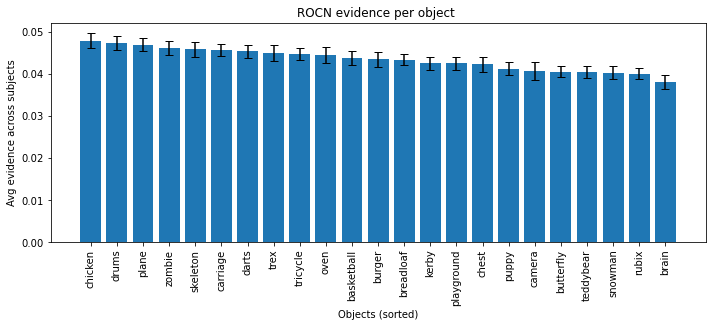


Top objects by avg evidence (ROCN | Average Across (GR and FR)):
 1: chicken         → 0.0479
 2: drums           → 0.0474
 3: plane           → 0.0470
 4: zombie          → 0.0462
 5: skeleton        → 0.0459
 6: carriage        → 0.0457
 7: darts           → 0.0454
 8: trex            → 0.0450
 9: tricycle        → 0.0448
10: oven            → 0.0446
11: basketball      → 0.0438
12: burger          → 0.0435
13: breadloaf       → 0.0433
-------------
14: kerby           → 0.0426
15: playground      → 0.0425
16: chest           → 0.0423
17: puppy           → 0.0412
18: camera          → 0.0407
19: butterfly       → 0.0406
20: teddybear       → 0.0405
21: snowman         → 0.0403
22: rubix           → 0.0401
23: brain           → 0.0381
[ 7 16 22  2 18  4 19 15  1  3  8 10 14  5  9 17 13 11 12  0  6 20 21]


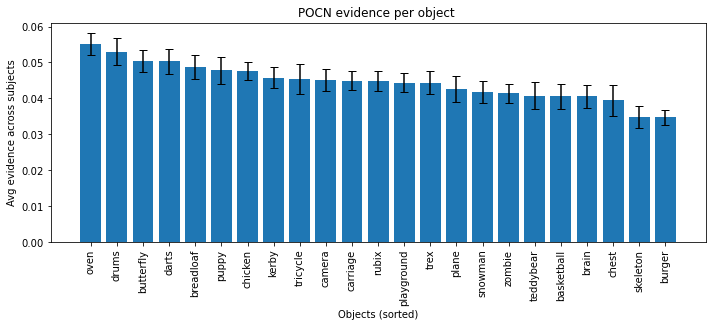


Top objects by avg evidence (POCN | Average Across (GR and FR)):
 1: oven            → 0.0552
 2: drums           → 0.0530
 3: butterfly       → 0.0504
 4: darts           → 0.0504
 5: breadloaf       → 0.0487
 6: puppy           → 0.0478
 7: chicken         → 0.0476
 8: kerby           → 0.0457
 9: tricycle        → 0.0454
10: camera          → 0.0452
11: carriage        → 0.0449
12: rubix           → 0.0449
13: playground      → 0.0444
14: trex            → 0.0444
15: plane           → 0.0426
-------------
16: snowman         → 0.0418
17: zombie          → 0.0414
18: teddybear       → 0.0408
19: basketball      → 0.0406
20: brain           → 0.0405
21: chest           → 0.0395
22: skeleton        → 0.0349
23: burger          → 0.0347


In [35]:
plot_best_objs('ROCN', 'GR', mean_result = True) # plots average between GR and FR
plot_best_objs('POCN', 'GR', mean_result = True) # plots average between GR and FR

## plot individual instead of group mean across GRs and FRs
# plot_best_objs('ROCN', 'GR', mean_result = False)
# plot_best_objs('POCN', 'GR', mean_result = False)
# plot_best_objs('ROCN', 'FR', mean_result = False)
# plot_best_objs('POCN', 'FR', mean_result = False)

In [23]:
plot_best_objs('ROCN', 'GR', mean_result = True)
plot_best_objs('POCN', 'GR', mean_result = True)

UnboundLocalError: local variable 'top_indices' referenced before assignment

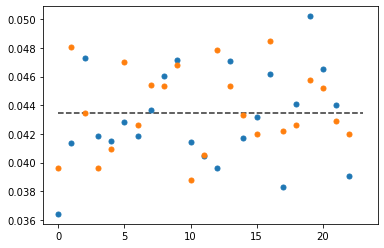

In [75]:
plt.plot(np.nanmean(unordered_rip['ROCN']['FR'], 1), '.', markersize=10)
plt.hlines(1/23,0,23, color='black', linestyle='--', alpha=0.5)

plt.plot(np.nanmean(unordered_rip['ROCN']['GR'], 1), '.', markersize=10)
plt.hlines(1/23,0,23, color='black', linestyle='--', alpha=0.5)




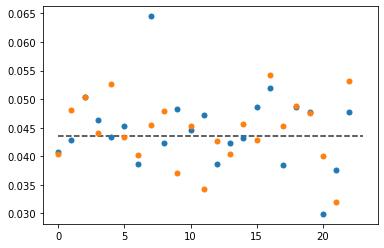

In [74]:
plt.plot(np.nanmean(unordered_rip['POCN']['GR'], 1), '.', markersize=10)
plt.hlines(1/23,0,23, color='black', linestyle='--', alpha=0.5)

plt.plot(np.nanmean(unordered_rip['POCN']['FR'], 1), '.', markersize=10)
plt.hlines(1/23,0,23, color='black', linestyle='--', alpha=0.5)

In [1]:
plot_best_objs('RRCN', 'GR', mean_result = True)
plot_best_objs('PRCN2', 'GR', mean_result = True)

NameError: name 'plot_best_objs' is not defined